In [17]:
# Базовые библиотеки
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Инструменты визуализации
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

# Машинное обучение
from sklearn.model_selection import train_test_split # для разделения на выборки
from sklearn.feature_selection import RFE, SelectKBest, f_classif # для отбора признаков
from sklearn.preprocessing import LabelEncoder, MinMaxScaler # для предобработки данных
from sklearn import linear_model # линейные модели
from sklearn import tree # решающие деревья
from sklearn import metrics # метрики
from sklearn import ensemble # ансамбли

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [18]:
# Загружаем данные
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [19]:
# Проверим данные на наличие явных пропусков
df.info()
# df.isnull().sum() # для подсчёта количества пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [20]:
# Изучив данные, можно заметить, что в некоторых записях встречаются значения 'unknown', которые мы тоже можем отнести к пропускам
# Выведем их количество

for column in df.columns: # запускаем цикл по столбцам
    u = (df[column] == 'unknown').sum() # считаем количество 'unknown' значений
    if u != 0:
        print(f"'{column}' - {u} неизвестных значений") # выводим столбец с количеством 'unknown' значений, если они есть

'job' - 70 неизвестных значений
'education' - 497 неизвестных значений
'contact' - 2346 неизвестных значений
'poutcome' - 8326 неизвестных значений


In [21]:
# Зададим функцию для перевода значения баланса из строки в число
# Для этого сначала удалим лишние символы и заменим запятую точкой
def get_balance(x):
    x = str(x)
    x = x.replace('$', '').replace(',', '.').replace(' ', '')
    x = float(x)
    return x

# Применим нашу функцию к столбцу
df['balance'] = df['balance'].apply(get_balance)

In [22]:
# Заменим пропуски в balance на медианные значения
df['balance'].fillna(df['balance'].median(), inplace=True)

In [23]:
# Обработаем неизвестные значения в признаках job и education, заменив их на модальные
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x)

In [24]:
# Рассчитаем 1-й и 3-й квартили, после этого найдём межквартильный размах
q_1, q_3 = df['balance'].quantile(0.25), df['balance'].quantile(0.75)
iqr = q_3 - q_1

# Находим границы, значения за пределами которых, будем считать выбросами
lower_bound, upper_bound = q_1 - (iqr * 1.5), q_3 + (iqr * 1.5)

# Удалим найденные выбросы
df_clean = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

print(f'Найдено выбросов по методу Тьюки: {df.shape[0] - df_clean.shape[0]}')
print(f'Количество записей после удаления выбросов: {df_clean.shape[0]}')

Найдено выбросов по методу Тьюки: 1057
Количество записей после удаления выбросов: 10105


## Часть 2:  Разведывательный анализ

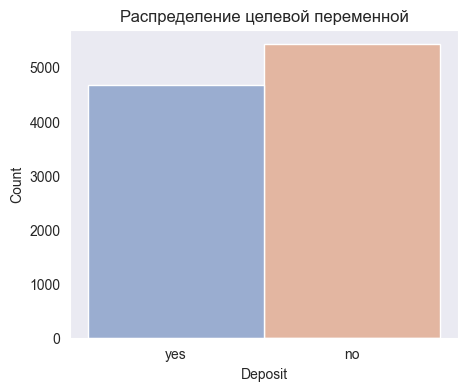

In [25]:
# Посмотрим на распределение целевой переменной
fig = plt.figure(figsize=(5, 4))
hist = sns.histplot(
    data = df_clean,
    x = 'deposit',
    hue = 'deposit',
    palette='deep',
    legend=False
    )

hist.set_title('Распределение целевой переменной');
hist.set_xlabel('Deposit');

# df_clean['deposit'].value_counts() # вывод точного количества

Классы приблизительно одинаковы. Можно сказать, что наши данные сбалансированы.

In [26]:
# Выведем основные статистические характеристики для количественных признаков
display(df_clean.describe())

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Обратив внимание на минимальные и максимальные значения, а также меры разброса, можно сделать вывод, что в наших данных присутствуют аномальные значения практически по всем признакам, за исключением ранее обработанного баланса.

Попробуем подробнее проанализировать данные признаки с помощью инструментов визуализации.

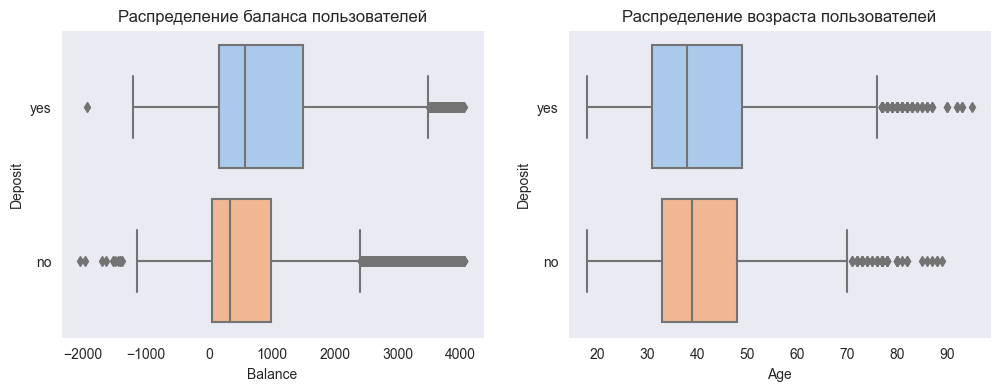

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

box_0 = sns.boxplot(
    data = df_clean,
    x = 'balance',
    y = 'deposit',
    palette='pastel',
    ax = axes[0]
    )

box_1 = sns.boxplot(
    data = df_clean,
    x = 'age',
    y = 'deposit',
    palette='pastel',
    ax = axes[1]
    )

box_0.set_title('Распределение баланса пользователей');
box_0.set_xlabel('Balance');
box_0.set_ylabel('Deposit');
box_1.set_title('Распределение возраста пользователей');
box_1.set_xlabel('Age');
box_1.set_ylabel('Deposit');

На левом графике представлено распределение баланса, в зависимости от наличия у клиента депозита в банке. Мы видим, что средний баланс клиентов с открытым депозитом выше, чем у клиентов без депозита. На правом графике также отображена зависимость целевой переменной, но уже от возраста клиента. Можно предположить, что распределение возраста в обоих классах примерно однинаковое, но всё же попробуем разбить наших клиентов по возрастным группам и визуализировать результаты.

In [28]:
# Зададим функцию, чтобы получить возрастную группу из возраста
def get_age_group(age):
    if age < 30:
        return '<30'
    elif age in list(range(30, 40)):
        return '30-40'
    elif age in list(range(40, 50)):
        return '40-50'
    elif age in list(range(50, 60)):
        return '50-60'
    else:
        return '60+'

# Создаём признак возрастной группы
df_clean['age_group'] = df_clean['age'].apply(get_age_group)

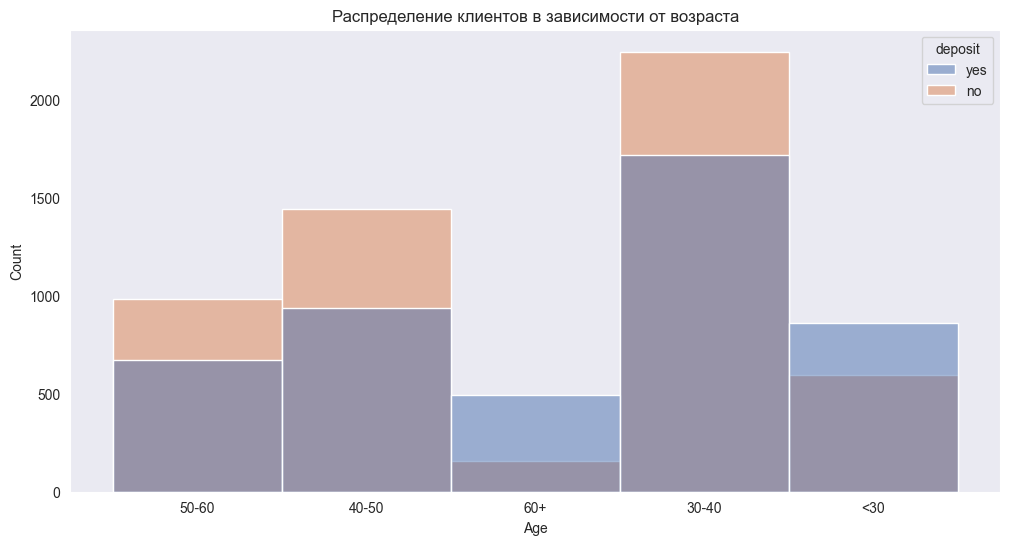

In [29]:
fig = plt.figure(figsize=(12, 6))
hist = sns.histplot(
    data = df_clean,
    x = 'age_group',
    hue='deposit',
    palette='deep'
    )

hist.set_title('Распределение клиентов в зависимости от возраста');
hist.set_xlabel('Age');

Хорошие показатели мы видим в возрастных группах - 'до 30 лет' и '60 лет и более', именно они более склонны к открытию депозита, чем к отказу от него.

In [30]:
# Выведем основные статистические характеристики для категориальных признаков
display(df_clean.describe(include='object'))

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit,age_group
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2,5
top,management,married,secondary,no,no,no,cellular,may,unknown,no,30-40
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424,3961


На основании данной таблицы можно определить, что в наших данных клиенты описываются 11 сферами занятости, чуть более половины из них состоят в браке, а самый популярный уровень образования - среднее. Также мы видим, что маркетинговые кампании проходят каждый месяц.

Попробуем определить какие клиенты с большей вероятностью захотят открыть депозит в банке.

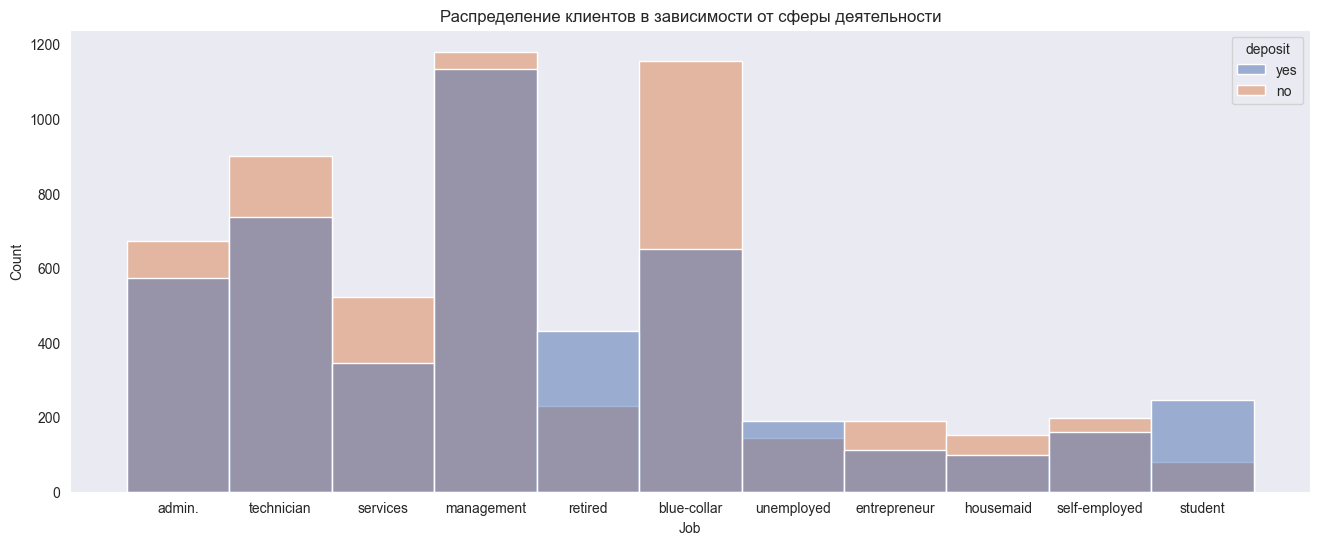

In [31]:
fig = plt.figure(figsize=(16, 6))

hist = sns.histplot(
    data = df_clean,
    x = 'job',
    hue = 'deposit',
    palette='deep'
    )

hist.set_title('Распределение клиентов в зависимости от сферы деятельности');
hist.set_xlabel('Job');

Студенты и клиенты на пенсии наиболее склонны к открытию депозита в банке, как раз это мы и увидели при анализе возрастных групп, а наименее склонны - производственные рабочие (blue-collar) и предприниматели. 

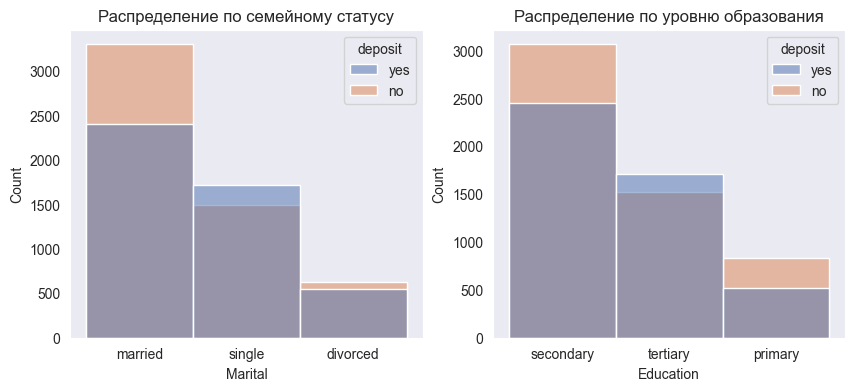

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

hist_0 = sns.histplot(
    data = df_clean,
    x = 'marital',
    hue = 'deposit',
    palette='deep',
    ax = axes[0]
    )

hist_1 = sns.histplot(
    data = df_clean,
    x = 'education',
    hue = 'deposit',
    palette='deep',
    ax = axes[1]
    )

hist_0.set_title('Распределение по семейному статусу');
hist_0.set_xlabel('Marital');
hist_1.set_title('Распределение по уровню образования');
hist_1.set_xlabel('Education');

На основании графиков можно сделать следующие выводы:
- Клиенты в браке менее склонны к открытию депозита, чем клиенты не в браке (в том числе разведённые);
- Клиенты со средним и начальным уровнями образования менее склонны к открытию депозита, чем клиенты с высшим образованием.

Теперь посмотрим на пересечения категорий по этим признакам. Сравним, какие сочетания уровня образования и семейного положения чаще и реже встречаются у клиентов открывших депозит и у клиентов без депозита.

In [33]:
# Разделим таблицы по признаку открытия депозита
df_dep_y = df_clean[(df_clean['deposit'] == 'yes')]
df_dep_n = df_clean[(df_clean['deposit'] == 'no')]

# Создадим сводные таблицы, где строки - уровень образования, а столбцы - семейное положение
pt_dep_y = df_dep_y.pivot_table(
    values='deposit',
    columns='marital',
    index='education',
    aggfunc='count'
)

pt_dep_n = df_dep_n.pivot_table(
    values='deposit',
    columns='marital',
    index='education',
    aggfunc='count'
)

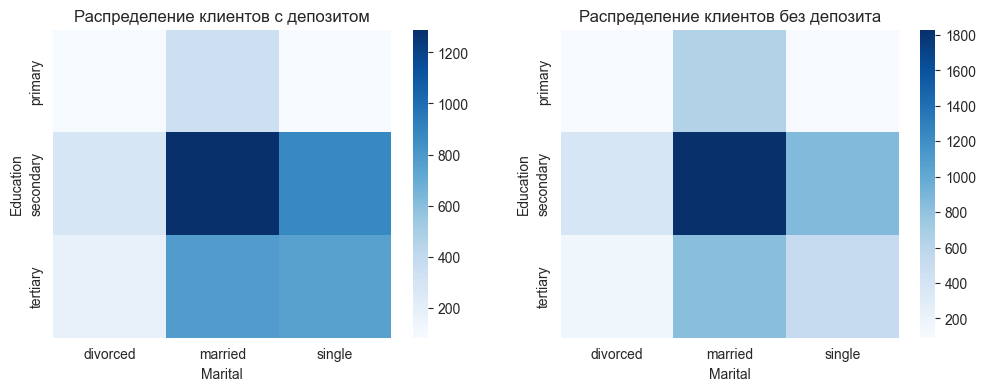

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

heat_0 = sns.heatmap(
    data = pt_dep_y,
    ax = axes[0],
    cmap='Blues'
    )

heat_1 = sns.heatmap(
    data = pt_dep_n,
    ax = axes[1],
    cmap='Blues'
    )

heat_0.set_title('Распределение клиентов с депозитом');
heat_0.set_xlabel('Marital');
heat_0.set_ylabel('Education');
heat_1.set_title('Распределение клиентов без депозита');
heat_1.set_xlabel('Marital');
heat_1.set_ylabel('Education');

Сравнив графики, мы видим, что в обоих случаях самая популярная категория совпала, это клиент со средним образованием, состоявший в браке. Зато прослеживаются различия в категориях 'teriraty' - 'married', 'single' и 'secondary' - 'single', на левом графике ячейки более тёмного цвета, то есть можно предположить, что такие клиенты более склонны к открытию депозита.

Обратим внимание на результаты предыдущей маркетинговой кампании. Возможно, люди, которые уже однажды согласились на предложение банка, согласятся принять его вновь, а может быть и наоборот.

In [35]:
df_clean['poutcome'].value_counts()

unknown    7570
failure    1109
success     945
other       481
Name: poutcome, dtype: int64

По большей части записей в данных мы не знаем результат предыдущей кампании, но есть около 2000 записей с известным результатом.

Узнаем соотношение успешных и провальных маркетинговых кампаний в зависимости от месяца, возможно это влияет на принятие решения.

In [36]:
# Отфильтруем данные по положительному и отрицательному исходу маркетинговой кампании, далее сгрупируем по месяцу и исходу
df_camp = df_clean[(df_clean['poutcome'] == 'failure') | (df_clean['poutcome'] == 'success')]
camp = df_camp.groupby(by=['month', 'poutcome'], as_index=False)['month'].value_counts()

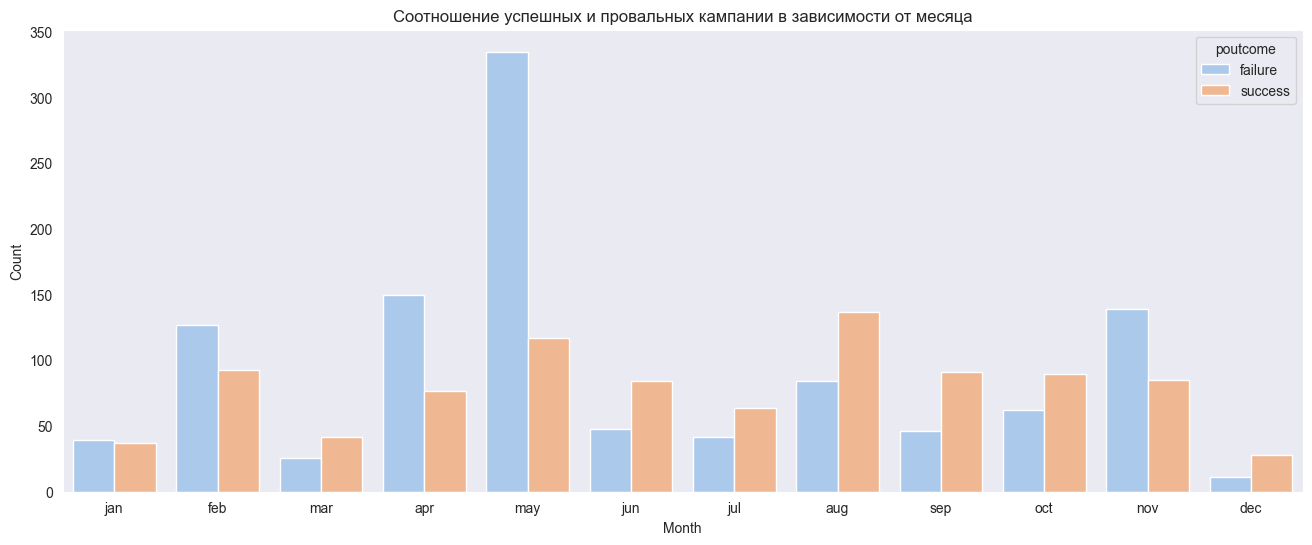

In [37]:
fig = plt.figure(figsize=(16, 6))
bar = sns.barplot(
    data = camp,
    x = 'month',
    y='count',
    hue='poutcome',
    palette='pastel', 
    order=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    )

bar.set_title('Соотношение успешных и провальных кампании в зависимости от месяца');
bar.set_xlabel('Month');
bar.set_ylabel('Count');

Хорошее соотношение мы наблюдаем летом, в марте, сентябре и октябре, а также в декабре, но по нему записей совсем немного. Обратную ситуацию мы видим в феврале, апреле, мае и ноябре, причём в мае сильно завышенное количество неудач, но и неплохое количество успехов.

Нам удалось немного проанализировать данные и сделать свои выводы, приступим к следующему этапу.

## Часть 3: Преобразование данных

Перед тем как перейти к построению модели, необходимо преобразовать категориальные признаки в более удобный формат, применить масштабирование и трансформировать некоторые признаки для того, чтобы улучшить качество модели, а потом отобрать признаки, которые мы будем использовать для обучения модели.

In [38]:
# Преобразуем признак уровня образования с помощью порядкового кодирования
encoder = LabelEncoder()
df_clean['education'] = encoder.fit_transform(df_clean['education'])
df_clean['education'].value_counts()

# Результат кодирования: 0 - начальное образование, 1 - среднее образование, 2 - высшее образование

1    5517
2    3239
0    1349
Name: education, dtype: int64

Ранее мы создали признак возрастной группы клиента, обработаем его по такому же принципу.

In [39]:
# Для корректного порядкового кодирования, сначала необходимо переименовать категорию 'до 30 лет'
df_clean['age_group'] = df_clean['age_group'].apply(lambda x: '0' if x == '<30' else x)
df_clean['age'] = encoder.fit_transform(df_clean['age_group'])
display(df_clean[['age', 'age_group']].value_counts()) # результат кодирования

# Можем удалить признак возрастной группы
df_clean.drop('age_group', axis=1, inplace=True)

age  age_group
1    30-40        3961
2    40-50        2382
3    50-60        1654
0    0            1455
4    60+           653
dtype: int64

Обычно в задачах бинарной классификации целевую переменную кодируют как бинарный признак, который принимает значения 1 или 0, так и сделаем.

In [40]:
print(f"До кодирования: '{df_clean['deposit'][0]}'")
df_clean['deposit'] = encoder.fit_transform(df_clean['deposit'])
print(f"После кодирования: {df_clean['deposit'][0]}")

До кодирования: 'yes'
После кодирования: 1


Сделаем то же самое для других бинарных переменных: 'default', 'housing', 'loan'.

In [41]:
print(f"До кодирования: '{df_clean['default'][0]}', '{df_clean['housing'][0]}', '{df_clean['loan'][0]}'")
df_clean['default'] = encoder.fit_transform(df_clean['default'])
df_clean['housing'] = encoder.fit_transform(df_clean['housing'])
df_clean['loan'] = encoder.fit_transform(df_clean['loan'])
print(f"После кодирования: '{df_clean['default'][0]}', '{df_clean['housing'][0]}', '{df_clean['loan'][0]}'")

До кодирования: 'no', 'yes', 'no'
После кодирования: '0', '1', '0'


Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений: 'job', 'marital', 'contact', 'month', 'poutcome'. Мы уже знаем, что количество уникальных категорий в этих признаках небольшое, поэтому применим 'горячее' кодирование.

In [42]:
# Запишем признаки для кодирования в новую переменную
to_encode = ['job', 'marital', 'contact', 'month', 'poutcome']
# Кодируем выбранные признаки и объединяем результат с исходной таблицей
dummies = pd.get_dummies(df_clean[to_encode])
df_clean = pd.concat([df_clean, dummies], axis=1)
# Удаляем исходные признаки
df_clean.drop(to_encode, axis=1, inplace=True)

Проверим наши признаки на мультиколлиниарность с помощью визуализации тепловой карты с коэффициентами корреляции.

Будем считать достаточно сильной корреляцию не менее 0.9.

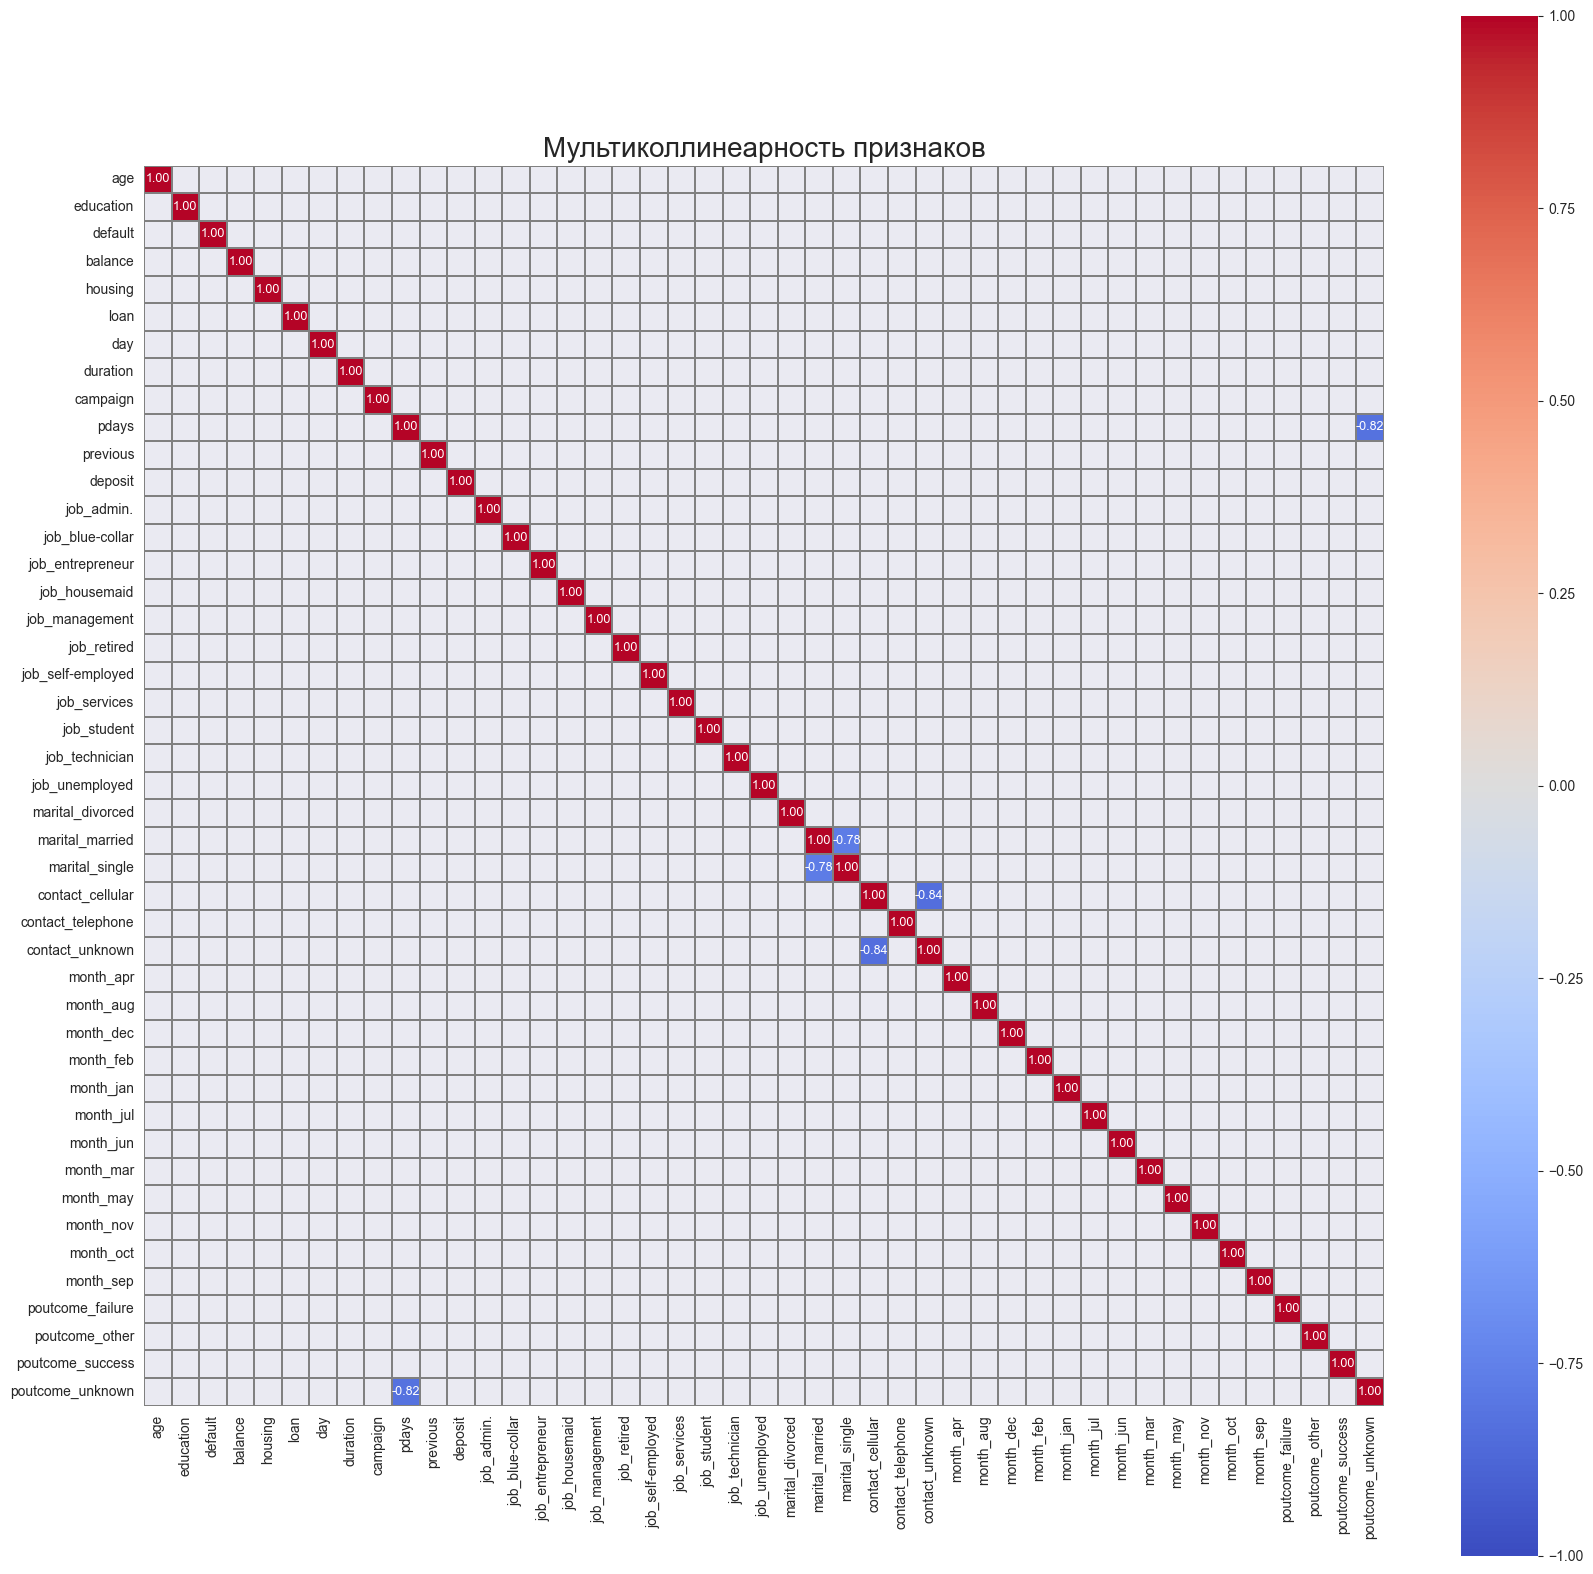

In [43]:
# В рамках учебного проекта рассчитываем коэффициент корреляции Пирсона,
# но для категориальных признаков лучше использовать коэффициент Спирмена
corr = df_clean.corr('pearson')

fig = plt.figure(figsize=(20, 20))
heat = sns.heatmap(
    data=corr[corr.abs() >= 0.7], # для читаемости отображаем только значения выше 0.7
    vmin=-1, 
    vmax=1, 
    linewidth=0.1, 
    linecolor='gray', 
    cmap='coolwarm',
    annot = True,
    annot_kws={'size': 9},
    fmt='.2f',
    square=True
)

heat.set_title('Мультиколлинеарность признаков', fontsize=20);

Для некоторых признаков прослеживается довольно таки сильная корреляция, но отметку 0.9 не превышает, поэтому оставим как есть.

Теперь необходимо выделить целевую переменную и предикторы, а также разделить данные на обучающую и тестовую выборки.

In [44]:
X = df_clean.drop('deposit', axis=1) # предикторы
y = df_clean['deposit'] # целевая переменная

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33, stratify=y)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Оставим лишь те, которые сильнее всего связаны с целевой переменной.

Для оценки взаимосвязи предикторов с целевой переменной с помощью статистических тестов применим SelectKBest и отберём 15 наилучших признаков.

In [45]:
selector = SelectKBest(f_classif, k=15) # в рамках учебного проекта используем F-тест для оценки линейной зависимости
selector.fit(X_train, y_train)
 
# Выводим отобранные признаки
selected_features = selector.get_feature_names_out().tolist()
selected_features

['balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

In [46]:
# Создаём DataFrame с отобранными столбцами
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

Теперь данные необходимо нормализовать. В рамках учебного проекта мы будем использовать min-max-нормализацию.

In [47]:
# Инициализируем нормализатор
scaler = MinMaxScaler()

# Нормализуем данные
X_train = scaler.fit_transform(X_train_sel) # обучаем на тренировочной выборке для избежания утечки данных
X_test = scaler.transform(X_test_sel)

# Преобразуем результат в DataFrame
X_train = pd.DataFrame(X_train, columns=X_train_sel.columns)
X_test = pd.DataFrame(X_test, columns=X_test_sel.columns)

# Часть 4: Решение задачи классификации

## Логистическая регрессия и решающие деревья

Для начала реализуем самый простой алгоритм — логистическую регрессию.

В качестве метода оптимизации функции потерь будем использовать 'sag', который является модификацией стохастического градиентного спуска, в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

In [48]:
# Инициализируем модель логистической регрессии и обучаем на тренировочной выборке
lr = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
lr.fit(X_train, y_train)

# Делаем предсказание классов для тренировочной выборки и тестовой
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Оцениваним результаты
print('Для тренировочной выборки: \n\n', metrics.classification_report(y_train, y_train_pred))
print('Для тестовой выборки: \n\n', metrics.classification_report(y_test, y_test_pred))


Для тренировочной выборки: 

               precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

Для тестовой выборки: 

               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



Модель логистической регрессии выдала хорошие результаты, причём для обеих выборок, что говорит об отсутствии переобучения и недообучения.

Попробуем построить модель решающего дерева. Для начала запустим модель с параметрами по умолчанию, только в качестве критерия информативности применим энтропию Шеннона и установим random_state для воспроизводимости.

In [49]:
# Инициализируем решающее дерево и обучаем на тренировочной выборке
dtc = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
dtc.fit(X_train, y_train)

# Делаем предсказание классов для тренировочной выборки и тестовой
y_train_pred = dtc.predict(X_train)
y_test_pred = dtc.predict(X_test)

# Оцениваним результаты
print('Для тренировочной выборки: \n\n', metrics.classification_report(y_train, y_train_pred))
print('Для тестовой выборки: \n\n', metrics.classification_report(y_test, y_test_pred))

Для тренировочной выборки: 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

Для тестовой выборки: 

               precision    recall  f1-score   support

           0       0.77      0.76      0.77      1790
           1       0.73      0.74      0.74      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



Мы получили явно переобученную модель, это связано с тем, что мы не задали никакие параметры остановки и получили очень сложное дерево, которое идеально подстроилось под тренировочную выборку.

Нам необходимо подобрать наилучшие параметры для нашей модели, для этого мы воспользуемся специальным инструментом Optuna.

In [50]:
# Импортируем Optuna
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) # для скрытия полного отчёта

# Задаём функцию, которую будем максимизировать
def optuna_dtc(trial):
  
  # Задаем пространства поиска гиперпараметров
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
  max_depth = trial.suggest_int('max_depth', 1, 10, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)

  # Инициализируем модель решающего дерева
  dtc = tree.DecisionTreeClassifier(
    criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, # подбираемые параметры
    random_state=42
    )
  
  # Обучаем модель на тренировочных данных
  dtc.fit(X_train, y_train)
  
  # Возвращаем значение метрики F1 score
  score = metrics.f1_score(y_test, dtc.predict(X_test))
  return score

# Создаём объект исследования и подбираем гиперпараметры
study = optuna.create_study(direction='maximize')
study.optimize(optuna_dtc, n_trials=100)

# Выводим наилучшие значения гиперпараметров
print('Наилучшие значения гиперпараметров: ', study.best_params)

# Создаём модель с наилучшими гиперпарметрами, обучаем её и делаем предсказания
dtc_best = tree.DecisionTreeClassifier(**study.best_params, random_state=42)
dtc_best.fit(X_train, y_train)
y_train_pred = dtc_best.predict(X_train)
y_test_pred = dtc_best.predict(X_test)

# Оцениваним результаты
print('\nДля тренировочной выборки: \n\n', metrics.classification_report(y_train, y_train_pred))
print('Для тестовой выборки: \n\n', metrics.classification_report(y_test, y_test_pred))

Наилучшие значения гиперпараметров:  {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1}

Для тренировочной выборки: 

               precision    recall  f1-score   support

           0       0.86      0.81      0.84      3634
           1       0.80      0.85      0.82      3136

    accuracy                           0.83      6770
   macro avg       0.83      0.83      0.83      6770
weighted avg       0.83      0.83      0.83      6770

Для тестовой выборки: 

               precision    recall  f1-score   support

           0       0.84      0.79      0.81      1790
           1       0.77      0.82      0.80      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.81      0.80      3335
weighted avg       0.81      0.80      0.80      3335



Обе модели показали хорошие результаты, они не сильно отличаются. Выбрать из них лучшую можно при наличии требований к их оценке.

Перейдём к более сложным алгоритмам машинного обучения.

## Ансамбли моделей

Теперь обучим модель случайного леса.

Для избежания переобучения сразу зададим некоторые параметры: минимальное число объектов в листе - 5, максимальная глубина дерева - 10.

In [51]:
rfc = ensemble.RandomForestClassifier(min_samples_leaf=5, max_depth=10, random_state=42)
rfc.fit(X_train, y_train)
y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)

# Оцениваним результаты
print('\nДля тренировочной выборки: \n\n', metrics.classification_report(y_train, y_train_pred))
print('Для тестовой выборки: \n\n', metrics.classification_report(y_test, y_test_pred))


Для тренировочной выборки: 

               precision    recall  f1-score   support

           0       0.87      0.85      0.86      3634
           1       0.83      0.86      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770

Для тестовой выборки: 

               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Мы сразу получаем наилучший результат по сравнению с предыдущими моделями. Попробуем его улучшить с помощью оптимизации гиперпараметров.

In [52]:
# Задаём функцию, которую будем максимизировать
def optuna_rfc(trial):
  
  # Задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 500, 10)
  max_depth = trial.suggest_int('max_depth', 10, 50, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15, 1)

  # Инициализируем модель случайного леса
  rfc = ensemble.RandomForestClassifier(
    n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, # подбираемые параметры
    random_state=42
    )
  
  # Обучаем модель на тренировочных данных
  rfc.fit(X_train, y_train)
  
  # Возвращаем значение метрики F1 score
  score = metrics.f1_score(y_test, rfc.predict(X_test))
  return score

# Создаём объект исследования и подбираем гиперпараметры
study = optuna.create_study(direction='maximize')
study.optimize(optuna_rfc, n_trials=50)

# Выводим наилучшие значения гиперпараметров
print('Наилучшие значения гиперпараметров: ', study.best_params)

# Создаём модель с наилучшими гиперпарметрами, обучаем её и делаем предсказания
rfc_best = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
rfc_best.fit(X_train, y_train)
y_train_pred = rfc_best.predict(X_train)
y_test_pred = rfc_best.predict(X_test)

# Оцениваним результаты
print('\nДля тренировочной выборки: \n\n', metrics.classification_report(y_train, y_train_pred))
print('Для тестовой выборки: \n\n', metrics.classification_report(y_test, y_test_pred))

Наилучшие значения гиперпараметров:  {'n_estimators': 190, 'max_depth': 10, 'min_samples_leaf': 15}

Для тренировочной выборки: 

               precision    recall  f1-score   support

           0       0.86      0.84      0.85      3634
           1       0.82      0.84      0.83      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

Для тестовой выборки: 

               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1790
           1       0.81      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Значительно улучшить результат для тестовой выборки не получается, попробуем применить модель градиентного бустинга.

Минимальное число объектов в листе также примем равным 5, а максимальную глубину дерева уменьшим до 5, так как бустинг лучше себя показывает на простых базовых моделях.

In [53]:
# Инициализируем модель, обучаем её, делаем предсказания и рассчитываем метрики
gbc = ensemble.GradientBoostingClassifier(min_samples_leaf=5, max_depth=5, random_state=42)
gbc.fit(X_train, y_train)
print('\nДля тренировочной выборки: \n\n', metrics.classification_report(y_train, gbc.predict(X_train)))
print('Для тестовой выборки: \n\n', metrics.classification_report(y_test, gbc.predict(X_test)))


Для тренировочной выборки: 

               precision    recall  f1-score   support

           0       0.89      0.85      0.87      3634
           1       0.84      0.88      0.86      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.87      0.86      6770
weighted avg       0.87      0.86      0.86      6770

Для тестовой выборки: 

               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Если подобрать наилучшие гиперпараметры, возможно, получится добиться результата даже лучше, чем у случайного леса.

In [54]:
# Задаём функцию, которую будем максимизировать
def optuna_gbc(trial):
  
  # Задаем пространства поиска гиперпараметров
  learning_rate = trial.suggest_float('learning_rate', 0.01, 1, step=0.1)
  n_estimators = trial.suggest_int('n_estimators', 100, 500, 10)
  max_depth = trial.suggest_int('max_depth', 1, 10, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)

  # Инициализируем модель случайного леса
  gbc = ensemble.GradientBoostingClassifier(
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    random_state=42
    )
  
  # Обучаем модель на тренировочных данных
  gbc.fit(X_train, y_train)
  
  # Возвращаем значение метрики F1 score
  score = metrics.f1_score(y_test, gbc.predict(X_test))
  return score

# Создаём объект исследования и подбираем гиперпараметры
study = optuna.create_study(direction='maximize')
study.optimize(optuna_gbc, n_trials=50)

# Выводим наилучшие значения гиперпараметров
print('Наилучшие значения гиперпараметров: ', study.best_params)

# Создаём модель с наилучшими парамерами, обучаем её, делаем предсказания и рассчитываем метрики
gbc_best = ensemble.GradientBoostingClassifier(**study.best_params, random_state=42)
gbc_best.fit(X_train, y_train)
print('\nДля тренировочной выборки: \n\n', metrics.classification_report(y_train, gbc_best.predict(X_train)))
print('Для тестовой выборки: \n\n', metrics.classification_report(y_test, gbc_best.predict(X_test)))

Наилучшие значения гиперпараметров:  {'learning_rate': 0.01, 'n_estimators': 410, 'max_depth': 7, 'min_samples_leaf': 3}

Для тренировочной выборки: 

               precision    recall  f1-score   support

           0       0.90      0.87      0.88      3634
           1       0.85      0.89      0.87      3136

    accuracy                           0.88      6770
   macro avg       0.88      0.88      0.88      6770
weighted avg       0.88      0.88      0.88      6770

Для тестовой выборки: 

               precision    recall  f1-score   support

           0       0.86      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Значительных изменений не видно, обе модели показали достойные результаты.

Теперь построим ансамбль из моделей разного типа, то есть используем стекинг, объединив те алгоритмы, которые мы применяли ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели будем использовать модель логистической регрессии.

In [55]:
# Задаём базовые модели
estimators = [
    ('lr', lr),
    ('dtc', dtc_best),
    ('gbc', gbc_best)
    ]

# Инициализируем классификатор
sc = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42),
    passthrough=True # для использования в обучение исходных принаков
)

# Обучаем модель, делаем предсказания и рассчитываем метрики
sc.fit(X_train, y_train)
print('\nДля тренировочной выборки: \n\n', metrics.classification_report(y_train, sc.predict(X_train)))
print('Для тестовой выборки: \n\n', metrics.classification_report(y_test, sc.predict(X_test)))


Для тренировочной выборки: 

               precision    recall  f1-score   support

           0       0.87      0.87      0.87      3634
           1       0.85      0.85      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Для тестовой выборки: 

               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.82      0.81      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Мы получили практически идентичные результаты.

Попробуем выяснить, какие признаки оказались наиболее значимыми для наших моделей.

In [56]:
# Инициализируем селектор на основе модели градиентного бустинга и обучаем
selector = RFE(gbc_best, n_features_to_select=3)
selector = selector.fit(X_train, y_train)

# Выводим 3 наиболее значимых признака
selector.get_feature_names_out()

array(['balance', 'duration', 'poutcome_success'], dtype=object)

Мы получили следующие признаки:

1. Продолжительность последнего контакта в контексте текущей маркетинговой кампании. Не удивительно, что этот признак оказал значительное влияние, скорее всего его значение будет гораздо выше для группы клиентов имеющих депозит в банке, чем у клиентов не имеющих его. Возможно, даже не совсем корректно использовать его для построения модели в реальной задаче, ведь продолжительный контакт с клиентом может напрямую означать открытие им депозита в банке, что в свою очередь является утечкой данных, тогда в реальных условиях такая модель не пригодится;
2. Неизвестный тип контакта с клиентом. Можно предположить, что с клиентом вовсе нет возможности связаться и он с очень низкой вероятностью захочет открыть депозит в банке, но на самом деле в наших данных даже для неизвестного типа контакта указана продолжительность последнего контакта. В реальной задаче нужно было бы выяснить, в каких случаях типу контакта присваивается значение 'unknown';
3. Успешный результат предыдущей маркетинговой кампании. Как и в случае с продолжительностью последнего контакта, такой признак стоило бы подробнее рассмотреть в реальных условиях. Возможно, успешным результатом маркетинговой кампании считалось как раз открытие клиентом депозита.

Проверка гипотез:

In [57]:
print('Средняя длительность последнего контакта для клиентов с открытым депозитом:',
      round(df[df['deposit'] == 'yes']['duration'].mean()), 'секунд')
print('Средняя длительность последнего контакта для клиентов без депозита:',
      round(df[df['deposit'] == 'no']['duration'].mean()), 'секунды')

Средняя длительность последнего контакта для клиентов с открытым депозитом: 537 секунд
Средняя длительность последнего контакта для клиентов без депозита: 223 секунды


In [58]:
print('Клиентов с открытым депозитом среди клиентов с указанным типом контакта:',
      round(df[df['contact'] != 'unknown']['deposit'].value_counts(normalize=True)['yes'] * 100), '%')
print('Клиентов с открытым депозитом среди клиентов с неизвестным типом контакта:',
      round(df[df['contact'] == 'unknown']['deposit'].value_counts(normalize=True)['yes'] * 100), '%')

Клиентов с открытым депозитом среди клиентов с указанным типом контакта: 54 %
Клиентов с открытым депозитом среди клиентов с неизвестным типом контакта: 23 %
